In [ ]:
##########
###20200121 Nejc Nate Dolensek, Nadine Gogolla - Gogolla Lab, Max-Planck-Institute of Neurobiology - Mouse Facial Expression Analysis v1
##########

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt 
from skimage import io
from skimage.feature import hog
from joblib import Parallel, delayed
import cv2
import glob

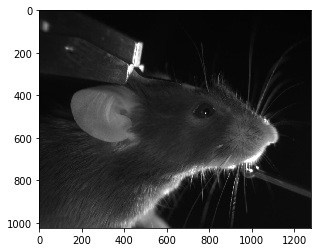

In [2]:
###example image - full frame

import matplotlib.image as mpimg
plt.imshow(mpimg.imread("E:/20200121_mouseFacialExpr_v1/protoFaces_1/neutral/neutral (27).jpg"), cmap="gray")

In [3]:
###Importing example data


#folder paths - adjust after saving
neutralFolder = "E:/20200121_mouseFacialExpr_v1/protoFaces_1/neutral/*.jpg"
painFolder = "E:/20200121_mouseFacialExpr_v1/protoFaces_1/pain/*.jpg"


#import crop coordinates 
import pickle 
with open("E:/20200121_mouseFacialExpr_v1/proto_cropCoords/proto_cropCoords.pkl", 'rb') as f:
     proto_cropCoords = pickle.load(f)    
     

#import prototypical faces
pickleDirPath = "E:/20200121_mouseFacialExpr_v1/protoFaces/"
from os import listdir
for i in listdir(pickleDirPath):
    vars()[i[:-4]] = pd.read_pickle(pickleDirPath + i)
    
#import tSNE data
pickleDirPath = "E:/20200121_mouseFacialExpr_v1/tSNE_faces/"
from os import listdir
for i in listdir(pickleDirPath):
    vars()[i[:-4]] = pd.read_pickle(pickleDirPath + i)    

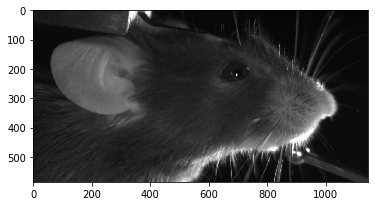

In [4]:
###example image - cropped

r = proto_cropCoords
plt.imshow(mpimg.imread("E:/20200121_mouseFacialExpr_v1/protoFaces_1/neutral/neutral (27).jpg")[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], cmap="gray")

In [5]:
###Preprocessing


#manually select the area containing the head of the mouse, 
#which will save the coordinates into a variable, to be used later.

def findCropCoords(imgFolderAndFileType):
    ###accepts folder containing image files in format "D:/folder1/folder2/folder3/*.jpg"
    ###waits for user to draw a rectangular selection
    ###outputs coordinates of a rectangular selection drawn over an image
    ###by default, the image displayed is the second image in the input folder
    import cv2
    from skimage import io
    
    coll = io.ImageCollection(imgFolderAndFileType)
    coords1 = cv2.selectROI("Image", coll[1]) 
    
    #cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return coords1

#replace the filepath below and uncomment for own use. In all following examples a set of preselected coordinated will be used 
#(imported in the cell above as proto_cropCoords)
#coords_1 = findCropCoords("D:/folder1/folder2/folder3/*.jpg")

In [6]:
###Data loading and preprocessing
#the imagesToHogsCellCrop() function will take all image files in a given folder, 
#crop the area as given in the cropCoords (use findCropCoords()) 
#and convert them into their HOG (histogram of oriented gradients) descriptors.
#pixels_per_cell argument defines the sliding window size for HOG creation.
# n_jobs argument defines number of threads used

def imagesToHogsCellCrop(imgFolderAndFileType, pixelsPerCell, cropCoords = []):
    from skimage import io
    from skimage.feature import hog
    from joblib import Parallel, delayed
    
    coll = io.ImageCollection(imgFolderAndFileType)
    
    if cropCoords == []:
        cropCoords = findCropCoords(imgFolderAndFileType)
    
    r = cropCoords
    
    kwargs = dict(orientations=8, pixels_per_cell=(pixelsPerCell, pixelsPerCell), cells_per_block=(1, 1), transform_sqrt=True)
    return Parallel(n_jobs=32)(delayed(hog)(image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], **kwargs) for image in coll)


#replace the filepath below for own use
sh_200uA_32 = imagesToHogsCellCrop("E:/20200121_mouseFacialExpr_v1/sh200_32/*.jpg", 32, cropCoords = proto_cropCoords)
sh_200uA_32 = pd.DataFrame(data = sh_200uA_32)


In [8]:
###Paiwrise similarity

#calculate similarities (correlation coefficients) between all possible pairs of frames
#stimuli are presented starting at frames #: 3600, 7260, 10920 for 60 frames each (2 seconds)
#here, 3 chunks containing 4s before each stimulus and 2s during each stimulus are selected
corr_pain = sh_200uA_32.iloc[np.r_[3480:3660, 7140:7320, 10800:10980]].T.corr()

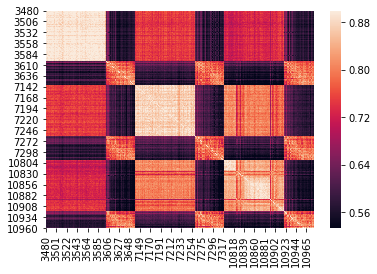

In [9]:
#clear repetitive pattern in the pairwise correlation matrix can be observed (follow the diagonal)
sns.heatmap(corr_pain, robust = True, rasterized = True)

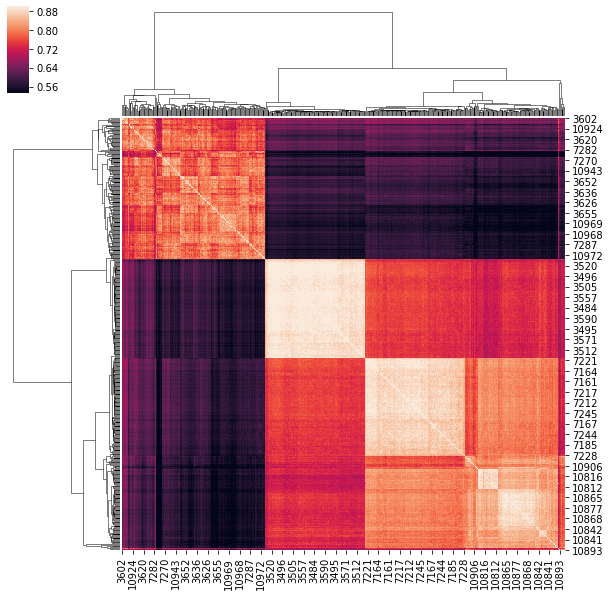

In [10]:
###Paiwrise similarity - hiearachical clustering

#hierarchically clustered pairwise correlation matrix
g = sns.clustermap(corr_pain, robust=True, rasterized = True)

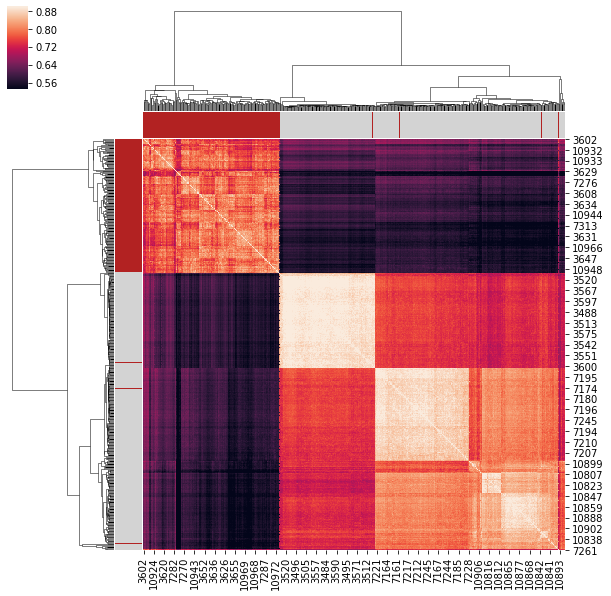

In [11]:
#post-hoc labelling the frames based on their temporal origin (gray = before each stimulus, red = during each stimulus) reveals 2 clusters
#after post-hoc labelling the frames based on their temporal origin (gray = before each stimulus, red = during each stimulus)
colorVec1 = (["lightgray"] * 120 + ["firebrick"] * 60) * 3
g = sns.clustermap(corr_pain, robust=True, col_colors = colorVec1, row_colors = colorVec1, rasterized = True)

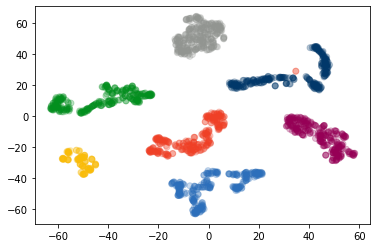

In [12]:
### Dimensionality reduction / clustering - tSNE and PCA


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#prepare colors for post-hoc coloring of points in the scatter plot
col_colors1 = 300 * ["grey"] + 300 * ["dark magenta"] + 300 * ["emerald green"] + 120 * ["golden rod"] + 300 * ["tomato"] + 300 * ["marine blue"] + 300 * ["medium blue"]
col_list_palette_pca = sns.xkcd_palette(col_colors1)

#tSNE_allEmotions variable contains a set of HOGs from a single animal experiencing varius stimuli/emotions.

#t-SNE reduces dimensions of each HOG to 2, which are plotted on a scatter plot and post-hoc
#colored based on the stimulus presented.
#Before running the t-SNE algorithm, number of dimensions are reduced to 100 using principal component analysis.
#gray = baseline, purple = bitter, green = sweet, gold/yellow = malaise, red = pain, dark blue = passive fear, light blue = active fear
pca2 = PCA(n_components=100)
pca2.fit(tSNE_allEmotions)
pcs2 = pca2.fit_transform(tSNE_allEmotions)
tsne2 = TSNE()
tsne_results2 = tsne2.fit_transform(pcs2)
plt.scatter(x = tsne_results2[:,0], y = tsne_results2[:,1], color = col_list_palette_pca, alpha = 0.25)
plt.show()




In [13]:
###Create neutral prototypical face

protoAll_neutral = imagesToHogsCellCrop(neutralFolder, 32, cropCoords = proto_cropCoords)
protoAll_neutral = pd.DataFrame(data = protoAll_neutral)
proto_neutral = protoAll_neutral.mean(axis = 0)

In [14]:
###functions which will be useful in the next steps of analysis

def findAlignParams(image, offset_image):
    ### this function will attempt to find optimal alignment parameters for a pair of images by employing 
    ### cross-correlation measurement in the fourier space
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import cv2

    from skimage.feature import register_translation
    from scipy.ndimage import fourier_shift


    image = image
    offset_image = offset_image

    # first rought XY alignment
    shift1, error1, diffphase1 = register_translation(image, offset_image)
    
    # apply correction
    offset_image2 = fourier_shift(np.fft.fftn(offset_image), shift1)
    offset_image2 = np.fft.ifftn(offset_image2)
    offset_image2 = np.array(offset_image2.real)
    offset_image2 = offset_image2.astype("uint8")
    
    # get image height, width
    (h, w) = image.shape[:2]
    # calculate the center of the image
    center = (w / 2, h / 2)
    scale = 1.0
    
    # find rotational alignment
    rotAngle1 = []
    rotError1 = []
    for i in range(-45,45):
        M = cv2.getRotationMatrix2D(center, i, 1)
        rotated_i = cv2.warpAffine(offset_image2, M, (w, h))
        
        shiftRot1, errorRot1, diffphaseRot1 = register_translation(image, rotated_i)
        
        rotAngle1.append(i)
        rotError1.append(errorRot1)
    
    # detect angle with the lowest error
    rot1_df = [rotAngle1, rotError1]
    rot1_df = pd.DataFrame(rot1_df)
    rot1_df = rot1_df.T
    minErrRowRot1 = rot1_df[1].idxmin()
    minErrAngleRot1 = rot1_df[0][minErrRowRot1]
    
    # apply rotational correction
    M = cv2.getRotationMatrix2D(center, minErrAngleRot1, 1)
    rotated1 = cv2.warpAffine(offset_image2, M, (w, h))
    
    
    # check for XY alignment again
    shift2, error2, diffphase2 = register_translation(image, rotated1)
    
    # apply XY correction again
    offset_image3 = fourier_shift(np.fft.fftn(rotated1), shift2)
    offset_image3 = np.fft.ifftn(offset_image3)
    offset_image3 = np.array(offset_image3.real)
    offset_image3 = offset_image3.astype("uint8")
    
    
    
    # check for scale alignment
    scale1 = []
    scaleError1 = []
    for i in np.arange(0.0, 2.0, 0.01):
        M = cv2.getRotationMatrix2D(center, 0, i)
        rescaled_i = cv2.warpAffine(offset_image3, M, (w, h))
        
        shiftScale1, errorScale1, diffphaseScale1 = register_translation(image, rescaled_i)
        
        scale1.append(i)
        scaleError1.append(errorScale1)
        
    scale1_df = [scale1, scaleError1]
    scale1_df = pd.DataFrame(scale1_df)
    scale1_df = scale1_df.T
    minErrRowScale1 = scale1_df[1].idxmin()
    minErrScale1 = scale1_df[0][minErrRowScale1]
    
    M = cv2.getRotationMatrix2D(center, 0, minErrScale1)
    scaledImg1 = cv2.warpAffine(offset_image3, M, (w, h))    
    
    
    return shift1, minErrAngleRot1, shift2, minErrScale1





def findAlignParamsFolder(imageFolder, offset_imageFolder):
    ### this function will attempt to find optimal alignment parameters for a pair of FOLDERS by employing 
    ### cross-correlation measurement in the fourier space
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import cv2
    import glob

    from skimage.feature import register_translation
    from scipy.ndimage import fourier_shift



    
    image = cv2.imread(glob.glob(imageFolder)[1],0)
    offset_image = cv2.imread(glob.glob(offset_imageFolder)[1],0)

    # first rought XY alignment
    shift1, error1, diffphase1 = register_translation(image, offset_image)
    
    # apply correction
    offset_image2 = fourier_shift(np.fft.fftn(offset_image), shift1)
    offset_image2 = np.fft.ifftn(offset_image2)
    offset_image2 = np.array(offset_image2.real)
    offset_image2 = offset_image2.astype("uint8")
    
    # get image height, width
    (h, w) = image.shape[:2]
    # calculate the center of the image
    center = (w / 2, h / 2)
    scale = 1.0
    
    # find rotational alignment
    rotAngle1 = []
    rotError1 = []
    for i in range(-45,45):
        M = cv2.getRotationMatrix2D(center, i, 1)
        rotated_i = cv2.warpAffine(offset_image2, M, (w, h))
        
        shiftRot1, errorRot1, diffphaseRot1 = register_translation(image, rotated_i)
        
        rotAngle1.append(i)
        rotError1.append(errorRot1)
    
    # detect angle with the lowest error
    rot1_df = [rotAngle1, rotError1]
    rot1_df = pd.DataFrame(rot1_df)
    rot1_df = rot1_df.T
    minErrRowRot1 = rot1_df[1].idxmin()
    minErrAngleRot1 = rot1_df[0][minErrRowRot1]
    
    # apply rotational correction
    M = cv2.getRotationMatrix2D(center, minErrAngleRot1, 1)
    rotated1 = cv2.warpAffine(offset_image2, M, (w, h))
    
    
    # check for XY alignment again
    shift2, error2, diffphase2 = register_translation(image, rotated1)
    
    # apply XY correction again
    offset_image3 = fourier_shift(np.fft.fftn(rotated1), shift2)
    offset_image3 = np.fft.ifftn(offset_image3)
    offset_image3 = np.array(offset_image3.real)
    offset_image3 = offset_image3.astype("uint8")
    
    
    
    # check for scale alignment
    scale1 = []
    scaleError1 = []
    for i in np.arange(0.0, 2.0, 0.01):
        M = cv2.getRotationMatrix2D(center, 0, i)
        rescaled_i = cv2.warpAffine(offset_image3, M, (w, h))
        
        shiftScale1, errorScale1, diffphaseScale1 = register_translation(image, rescaled_i)
        
        scale1.append(i)
        scaleError1.append(errorScale1)
        
    scale1_df = [scale1, scaleError1]
    scale1_df = pd.DataFrame(scale1_df)
    scale1_df = scale1_df.T
    minErrRowScale1 = scale1_df[1].idxmin()
    minErrScale1 = scale1_df[0][minErrRowScale1]
    
    M = cv2.getRotationMatrix2D(center, 0, minErrScale1)
    scaledImg1 = cv2.warpAffine(offset_image3, M, (w, h))    
    
    
    return shift1, minErrAngleRot1, shift2, minErrScale1







def alignFunc1(offset_image, shift1, minErrAngleRot1, shift2, minErrScale1):
    ###This is a utility function which takes the parameters output by findAlignParams() function
    ###and uses them to transform and align a given unaligned image
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.feature import register_translation
    from scipy.ndimage import fourier_shift
    import cv2
    
    # get image height, width
    (h, w) = offset_image.shape[:2]
    # calculate the center of the image
    center = (w / 2, h / 2)
    scale = 1.0
    
    offset_image2 = fourier_shift(np.fft.fftn(offset_image), shift1)
    offset_image2 = np.fft.ifftn(offset_image2)
    offset_image2 = np.array(offset_image2.real)
    offset_image2 = offset_image2.astype("uint8")
        
    M = cv2.getRotationMatrix2D(center, minErrAngleRot1, 1)
    rotated1 = cv2.warpAffine(offset_image2, M, (w, h))
        
    offset_image3 = fourier_shift(np.fft.fftn(rotated1), shift2)
    offset_image3 = np.fft.ifftn(offset_image3)
    offset_image3 = np.array(offset_image3.real)
    offset_image3 = offset_image3.astype("uint8")
        
    M = cv2.getRotationMatrix2D(center, 0, minErrScale1)
    scaledImg1 = cv2.warpAffine(offset_image3, M, (w, h))
    
    return scaledImg1





def imagesToHogsCellCropAlign(imgFolderAndFileType, pixelsPerCell, cropCoords, shift1, minErrAngleRot1, shift2, minErrScale1):
    ###this function will crop, align and convert to HOGs a folder of images, based on specific transformation parameters,
    ###as output by findAlignParams() - they need to be manually specificed. Useful when parameters have been precalculated,
    ###for example when aligning a set of recordings of the same mouse, acquired on the same day.
    from skimage import io
    from skimage.feature import hog
    from joblib import Parallel, delayed
    
    coll = io.ImageCollection(imgFolderAndFileType)
    
    if cropCoords == []:
        cropCoords = findCropCoords(imgFolderAndFileType)
    
    r = cropCoords
    
    kwargs = dict(orientations=8, pixels_per_cell=(pixelsPerCell, pixelsPerCell), cells_per_block=(1, 1), transform_sqrt=True)
    return Parallel(n_jobs=13)(delayed(hog)(alignFunc1(image)[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], **kwargs) for image in coll)



def imagesToHogsCellCropAlignFolder(imageFolder, offset_imageFolder, pixelsPerCell, cropCoords):
    from skimage import io
    from skimage.feature import hog
    from joblib import Parallel, delayed
    #import cv2
    #import glob
    
    
    shift1, minErrAngleRot1, shift2, minErrScale1 = findAlignParamsFolder(imageFolder, offset_imageFolder)
    
    #image = cv2.imread(glob.glob(imageFolder)[1],0)
    #offset_image = cv2.imread(glob.glob(offset_imageFolder)[1],0)
    
    coll = io.ImageCollection(offset_imageFolder)
    
    
    
    if cropCoords == []:
        cropCoords = findCropCoords(offset_imageFolder)
    
    r = cropCoords

    tempAlignedIms = Parallel(n_jobs=60)(delayed(alignFunc1)(image, shift1, minErrAngleRot1, shift2, minErrScale1) for image in coll)
    
    kwargs = dict(orientations=8, pixels_per_cell=(pixelsPerCell, pixelsPerCell), cells_per_block=(1, 1), transform_sqrt=True)
    return Parallel(n_jobs=60)(delayed(hog)(image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], **kwargs) for image in tempAlignedIms)



def imagesToHogsCellCrop(imgFolderAndFileType, pixelsPerCell, cropCoords = []):
    ###this function converts images (frames) into HOG descriptors and crops them based on given crop coordinates (cropCoords)
    ###if no crop coordinates are given, an interactive window will open and prompt the user to draw a bounding box
    ###indicating the desired cropped area
    from skimage import io
    from skimage.feature import hog
    from joblib import Parallel, delayed
    
    coll = io.ImageCollection(imgFolderAndFileType)
    
    if cropCoords == []:
        cropCoords = findCropCoords(imgFolderAndFileType)
    
    r = cropCoords
    
    kwargs = dict(orientations=8, pixels_per_cell=(pixelsPerCell, pixelsPerCell), cells_per_block=(1, 1), transform_sqrt=True)
    return Parallel(n_jobs=13)(delayed(hog)(image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], **kwargs) for image in coll)




def visAlign(image, offset_image):
    ### this function will compare how aligned 2 datasets were before and after alignment and takes images as input
    ### if alignment has resulted in an improvement, imagesToHogsCellCropAlignFolder() is the recommended follow-up
    ### if it has not or the difference is small, imagesToHogsCellCrop() is the recommended follow-up since 
    ### imagesToHogsCellCropAlignFolder() results in a heavy perforance penalty for descriptor creation
    import numpy as np
    import matplotlib.pyplot as plt 
    
    im0 = image
    im1 = offset_image
    a2_1 = np.dstack((im0, im1, np.zeros(im0.shape).astype("uint8")))
    a2_2 = np.dstack((im0, alignFunc1(im1), np.zeros(im0.shape).astype("uint8")))    
    
    f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1)
    ax1.imshow(a2_1)
    ax2.imshow(a2_2)
    ax1.axis('off')
    ax1.set_title("original")
    ax2.axis('off')
    ax2.set_title("aligned")
    
    
def visAlignFolder(imageFolder, offset_imageFolder):
    ### this function will compare how aligned 2 datasets were before and after alignment and takes folders as input
    ### if alignment has resulted in an improvement, imagesToHogsCellCropAlignFolder() is the recommended follow-up
    ### if it has not or the difference is small, imagesToHogsCellCrop() is the recommended follow-up since 
    ### imagesToHogsCellCropAlignFolder() results in a heavy perforance penalty for descriptor creation
    import numpy as np
    import matplotlib.pyplot as plt 
    import cv2
    import glob
    
    image = cv2.imread(glob.glob(imageFolder)[1],0)
    offset_image = cv2.imread(glob.glob(offset_imageFolder)[1],0)
    
    shift1, minErrAngleRot1, shift2, minErrScale1 = findAlignParams(image, offset_image)
    
    a2_1 = np.dstack((image, offset_image, np.zeros(image.shape).astype("uint8")))
    a2_2 = np.dstack((image, alignFunc1(offset_image, shift1, minErrAngleRot1, shift2, minErrScale1), np.zeros(image.shape).astype("uint8")))    
    
    f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1)
    ax1.imshow(a2_1)
    ax2.imshow(a2_2)
    ax1.axis('off')
    ax1.set_title("original")
    ax2.axis('off')
    ax2.set_title("aligned")

C:\Users\ndolensek\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\register_translation.py:103: RuntimeWarning: invalid value encountered in cdouble_scalars
  (src_amp * target_amp)


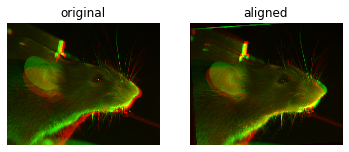

In [15]:
####Aligning data - example

visAlignFolder(neutralFolder, painFolder)

In [16]:
protoAll_pain = imagesToHogsCellCropAlignFolder(neutralFolder, painFolder, 32, proto_cropCoords) #Align and create pain HOGs
protoAll_pain = pd.DataFrame(data = protoAll_pain) #this is data from a single example tail shock presentation, shock onset is at 50f and it lasts until 110f

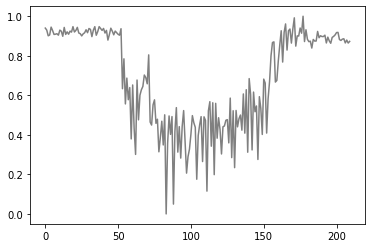

In [17]:
####Creating an emotion prototype - example

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
t1 = protoAll_pain.corrwith(proto_neutral, axis = 1) #comparing this single tail shock presentation to the neutral prototypical face we created above
plt.plot(scaler.fit_transform(t1.to_numpy().reshape(-1, 1)), color = "gray")

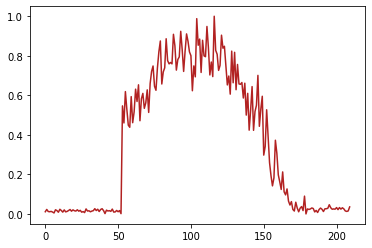

In [18]:
proto_pain = protoAll_pain.iloc[t1.nsmallest(10).index].mean(axis = 0) #10 frames most dissimilar to the neutral face are averaged and used to form the prototypical pain face

t2 = protoAll_pain.corrwith(proto_pain, axis = 1)
plt.plot(scaler.fit_transform(t2.to_numpy().reshape(-1, 1)), color = "firebrick")

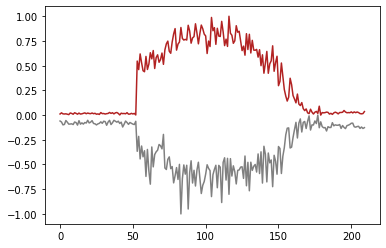

In [19]:
plt.plot(scaler.fit_transform(t1.to_numpy().reshape(-1, 1)) - 1, color = "gray") #neutral face similarity
plt.plot(scaler.fit_transform(t2.to_numpy().reshape(-1, 1)), color = "firebrick") #pain face similarity. They follow almost, but not completely, inverted paths

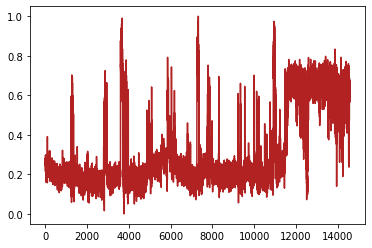

In [20]:
###Measuring prototypical face similarity - example

t3 = sh_200uA_32.corrwith(proto_pain, axis = 1)
plt.plot(scaler.fit_transform(t3.to_numpy().reshape(-1, 1)), color = "firebrick")

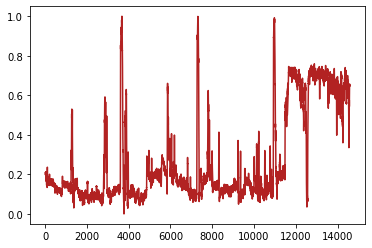

In [22]:
# data can be smoothed with a short rolling window
t4 = sh_200uA_32.corrwith(proto_pain, axis = 1).rolling(window=10).mean() #short rolling window reduces noise
plt.plot(scaler.fit_transform(t4.to_numpy().reshape(-1, 1)), color = "firebrick")

Accuracy neutral: 0.9925925925925926


C:\Users\ndolensek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


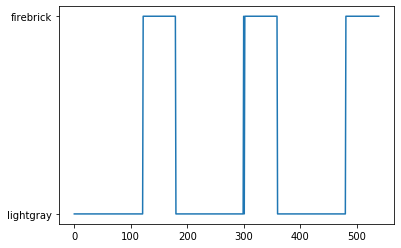

In [23]:
###Discrete classification

#a random forest classifier trained to be able to distinguish between neutral ("lightgray" labelled frames)
#and painful ("firebrick" labelled frames) facial expressions. We will train the classifier on 15% of all data
#and test it on all 3 stimulus presentations.

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

qq1 = sh_200uA_32.iloc[np.r_[3480:3660, 7140:7320, 10800:10980]].reset_index(drop=True)
train_features = qq1.sample(frac=0.15)
df_col_colors1 = pd.DataFrame(colorVec1)
train_labels = df_col_colors1.iloc[train_features.index]
rf_1 = RandomForestClassifier()
rf_1.fit(train_features, train_labels)
predictions_1 = rf_1.predict(sh_200uA_32.iloc[np.r_[3480:3660, 7140:7320, 10800:10980]])
print("Accuracy neutral:",metrics.accuracy_score(colorVec1, predictions_1))

plt.plot(predictions_1)



C:\Users\ndolensek\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


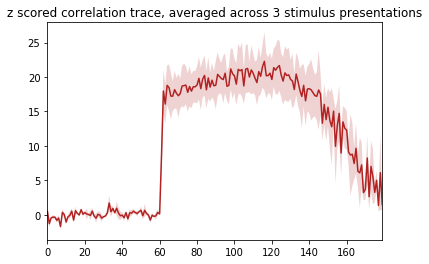

In [24]:
###Statistical processing of prototype similarity traces

def tsplotSlice_uneq(animalName, corrData, shockStartTimepoints, windowMinus, windowPlus):
    ### This is a utility function which will slice a trace (usually similarity to protoypical face) in such
    ### a way to produce a wide format dataframe taken by seaborn.tsplot() plotting function where each column
    ### contains pre-stimulus and post-stimulus information for a single stimulus presentation.
    ### animalName is a string containing the name of the animal (since column names cannot be empty)
    ### corrData is the similarity trace data
    ### shockStartTimepoints is a list of stimulus onset times
    ### windowMinus is the duration of pre-stimulus interval
    ### windowPlus is the duration of post-stimulus interval
    import pandas as pd
    
    counter = 0
    tempDf1 = pd.DataFrame()
    for i in shockStartTimepoints:
        temp1 = corrData[(i - windowMinus) : (i + windowPlus)].values
        tempDf1[animalName + "_" + str(counter)] = temp1

        counter = counter + 1
        
    return tempDf1


def all1_customAns_customStarts(listAns, protoFace, stimStartTimepoints):
    ### this function correlates a list of variables containing HOG descriptors to a prototypical face and outputs 
    ### a wide format dataframe where each column contains a slice of these correlation traces around a single stimulus
    ### presentation.
    ### listAns is a list of variable names containing HOG data. 
    ### protoFace is a relevant prototypical face with which to perform the similarity comparison
    ### stimStartTimepoints is a list containing frame numbers denoting stimulus starts
    counter1 = 1
    res1 = pd.DataFrame()
    for i in listAns:
        temp1 = tsplotSlice_uneq("an3_sh600_" + str(counter1), i.corrwith(protoFace, axis = 1), stimStartTimepoints, 60, 120)
        res1 =  pd.concat([res1, temp1],axis=1, sort=False)
        counter1 += 1
        
    return res1

def flexiZscore_firstMean_all(df, baselineStart = 0, baselineEnd = 60, onlyMeanSubstraction = False):
    ### this function takes the output of all1_customAns_customStarts() and normalizes each column (=each stimulus presentation)
    ### to a selected baseline (first 60 frames by default). onlyMeanSubstraction argument will normalize each column
    ### by subtracting the baseline mean when set to True and will calculate a Z score using baseline
    ### mean and standard deviation when set to False
    import numpy as np
    import pandas as pd
    
    dfTemp1 = df.iloc[baselineStart:baselineEnd]
    if onlyMeanSubstraction == False:
        df_zscore = (df - dfTemp1.mean())/dfTemp1.std()
    elif onlyMeanSubstraction == True:
        df_zscore = (df - dfTemp1.mean())
    
    return df_zscore

shockStartsEmpathy_2s = [120*30, (120*2 + 1*2)*30, (120*3 + 2*2)*30]

suc1_all = all1_customAns_customStarts([sh_200uA_32], proto_pain, shockStartsEmpathy_2s)
suc1_all_z = flexiZscore_firstMean_all(suc1_all, onlyMeanSubstraction = False)

sns.tsplot(suc1_all_z.T.values, color = "firebrick")
plt.title("z scored correlation trace, averaged across 3 stimulus presentations")
plt.show()